In [1]:
#TIME WINDOW = 1HR
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


                               DateTime  Voltage Line 1 [V]  \
DateTime                                                      
2020-08-02 00:00:00 2020-08-02 00:00:00              232.39   
2020-08-02 01:00:00 2020-08-02 01:00:00              234.30   
2020-08-02 02:00:00 2020-08-02 02:00:00              234.14   
2020-08-02 03:00:00 2020-08-02 03:00:00              234.99   
2020-08-02 04:00:00 2020-08-02 04:00:00              233.60   
...                                 ...                 ...   
2020-11-30 19:00:00 2020-11-30 19:00:00              233.59   
2020-11-30 20:00:00 2020-11-30 20:00:00              233.99   
2020-11-30 21:00:00 2020-11-30 21:00:00              233.38   
2020-11-30 22:00:00 2020-11-30 22:00:00              233.50   
2020-11-30 23:00:00 2020-11-30 23:00:00              232.89   

                     Voltage Line 2 [V]  Voltage Line 3 [V]  \
DateTime                                                      
2020-08-02 00:00:00              232.27              2

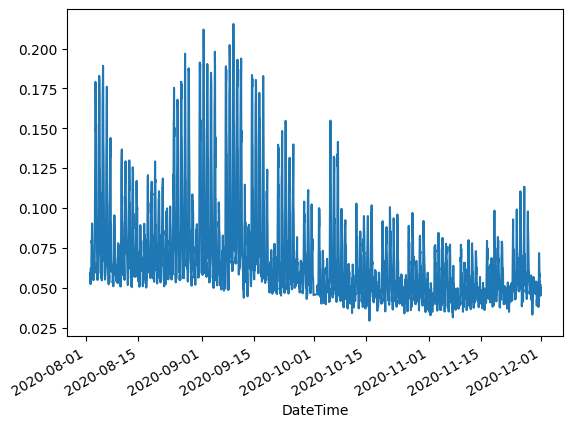

In [2]:
df = pd.read_csv('meter1_combined.csv')
df.DateTime = pd.to_datetime(df.DateTime,dayfirst=True)
df.index = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S')
df["Active Total Energy in MWh"]= df['Active Total Energy (Wh) [Wh]'].astype(float)/ 1000000
df["Combined Active Power in MW"] = df['Combined Active Power Line 1+2 +3 (watt)'].astype(float) / 1000000
print(df)
df['Combined Active Power in MW'].plot()
# plt.show()
target= df['Combined Active Power in MW']

In [3]:
#Convert TimeSeries
#MODEL WITH JUST POWER
def df_to_X_y(df, window_size=1):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

#Convert TimeSeries
#Uses 5 hrs to predict the next hour ....
WINDOW_SIZE = 1
X1, y1 = df_to_X_y(target, WINDOW_SIZE)
X1.shape, y1.shape

((2877, 1, 1), (2877,))

In [4]:
X_train1, y_train1 = X1[:2000], y1[:2000]
X_val1, y_val1 = X1[2000:2435], y1[2000:2435]
X_test1, y_test1 = X1[2435:], y1[2435:]
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(2000, 1, 1) (2000,) (435, 1, 1) (435,) (442, 1, 1) (442,)


In [5]:
model1 = Sequential()
model1.add(InputLayer((1, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [6]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [7]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

Epoch 1/50
63/63 [==============================] - 3s 13ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 5.4597e-04 - val_root_mean_squared_error: 0.0234


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 2/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0494 - val_loss: 1.5921e-04 - val_root_mean_squared_error: 0.0126


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 3/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 3.9269e-04 - val_root_mean_squared_error: 0.0198
Epoch 4/50
63/63 [==============================] - 0s 2ms/step - loss: 9.5931e-04 - root_mean_squared_error: 0.0309 - val_loss: 5.5585e-04 - val_root_mean_squared_error: 0.0236
Epoch 5/50
63/63 [==============================] - 0s 2ms/step - loss: 8.7890e-04 - root_mean_squared_error: 0.0296 - val_loss: 5.8486e-04 - val_root_mean_squared_error: 0.0242
Epoch 6/50
63/63 [==============================] - 0s 2ms/step - loss: 8.8871e-04 - root_mean_squared_error: 0.0298 - val_loss: 5.7483e-04 - val_root_mean_squared_error: 0.0240
Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 8.7885e-04 - root_mean_squared_error: 0.0296 - val_loss: 5.4518e-04 - val_root_mean_squared_error: 0.0233
Epoch 8/50
63/63 [==============================] - 0s 2ms/step - loss: 7.8458e-04 - root_mean_squared_error: 0.02

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 26/50
63/63 [==============================] - 0s 2ms/step - loss: 2.6250e-04 - root_mean_squared_error: 0.0162 - val_loss: 1.4911e-04 - val_root_mean_squared_error: 0.0122


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 27/50
63/63 [==============================] - 0s 2ms/step - loss: 2.2337e-04 - root_mean_squared_error: 0.0149 - val_loss: 1.2920e-04 - val_root_mean_squared_error: 0.0114


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 28/50
63/63 [==============================] - 0s 2ms/step - loss: 2.3232e-04 - root_mean_squared_error: 0.0152 - val_loss: 1.1225e-04 - val_root_mean_squared_error: 0.0106


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 29/50
63/63 [==============================] - 0s 2ms/step - loss: 2.3327e-04 - root_mean_squared_error: 0.0152 - val_loss: 1.1026e-04 - val_root_mean_squared_error: 0.0105


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 30/50
63/63 [==============================] - 0s 2ms/step - loss: 2.0836e-04 - root_mean_squared_error: 0.0144 - val_loss: 9.9011e-05 - val_root_mean_squared_error: 0.0100


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 31/50
63/63 [==============================] - 0s 2ms/step - loss: 1.6761e-04 - root_mean_squared_error: 0.0129 - val_loss: 9.1071e-05 - val_root_mean_squared_error: 0.0095


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 32/50
63/63 [==============================] - 0s 2ms/step - loss: 1.9720e-04 - root_mean_squared_error: 0.0140 - val_loss: 7.1860e-05 - val_root_mean_squared_error: 0.0085


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 33/50
63/63 [==============================] - 0s 2ms/step - loss: 1.7179e-04 - root_mean_squared_error: 0.0131 - val_loss: 6.2320e-05 - val_root_mean_squared_error: 0.0079


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 34/50
63/63 [==============================] - 0s 2ms/step - loss: 1.7779e-04 - root_mean_squared_error: 0.0133 - val_loss: 5.7204e-05 - val_root_mean_squared_error: 0.0076


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 35/50
63/63 [==============================] - 0s 2ms/step - loss: 1.6483e-04 - root_mean_squared_error: 0.0128 - val_loss: 5.6070e-05 - val_root_mean_squared_error: 0.0075


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 36/50
63/63 [==============================] - 0s 2ms/step - loss: 1.6561e-04 - root_mean_squared_error: 0.0129 - val_loss: 5.8618e-05 - val_root_mean_squared_error: 0.0077
Epoch 37/50
63/63 [==============================] - 0s 2ms/step - loss: 1.6315e-04 - root_mean_squared_error: 0.0128 - val_loss: 4.8919e-05 - val_root_mean_squared_error: 0.0070


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 38/50
63/63 [==============================] - 0s 2ms/step - loss: 1.6703e-04 - root_mean_squared_error: 0.0129 - val_loss: 4.8804e-05 - val_root_mean_squared_error: 0.0070


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 39/50
63/63 [==============================] - 0s 2ms/step - loss: 1.4595e-04 - root_mean_squared_error: 0.0121 - val_loss: 4.6759e-05 - val_root_mean_squared_error: 0.0068


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 40/50
63/63 [==============================] - 0s 2ms/step - loss: 1.6183e-04 - root_mean_squared_error: 0.0127 - val_loss: 4.6790e-05 - val_root_mean_squared_error: 0.0068
Epoch 41/50
63/63 [==============================] - 0s 2ms/step - loss: 1.4825e-04 - root_mean_squared_error: 0.0122 - val_loss: 4.4193e-05 - val_root_mean_squared_error: 0.0066


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 42/50
63/63 [==============================] - 0s 2ms/step - loss: 1.5429e-04 - root_mean_squared_error: 0.0124 - val_loss: 5.2444e-05 - val_root_mean_squared_error: 0.0072
Epoch 43/50
63/63 [==============================] - 0s 2ms/step - loss: 1.4157e-04 - root_mean_squared_error: 0.0119 - val_loss: 4.4537e-05 - val_root_mean_squared_error: 0.0067
Epoch 44/50
63/63 [==============================] - 0s 2ms/step - loss: 1.3782e-04 - root_mean_squared_error: 0.0117 - val_loss: 5.6379e-05 - val_root_mean_squared_error: 0.0075
Epoch 45/50
63/63 [==============================] - 0s 2ms/step - loss: 1.5062e-04 - root_mean_squared_error: 0.0123 - val_loss: 4.8163e-05 - val_root_mean_squared_error: 0.0069
Epoch 46/50
63/63 [==============================] - 0s 2ms/step - loss: 1.4841e-04 - root_mean_squared_error: 0.0122 - val_loss: 5.3534e-05 - val_root_mean_squared_error: 0.0073
Epoch 47/50
63/63 [==============================] - 0s 2ms/step - loss: 1.4612e-04 - root_mean_squared_e

In [8]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})

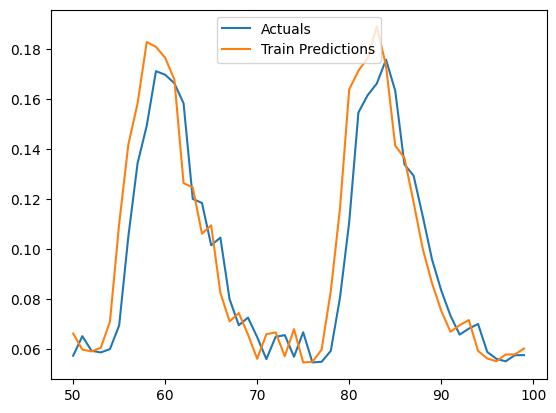

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])
plt.legend(['Actuals','Train Predictions'])
plt.show()

In [10]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,0.051425,0.046778
1,0.047542,0.055130
2,0.055093,0.049332
3,0.049849,0.054107
4,0.054167,0.053055
...,...,...
430,0.054214,0.061506
431,0.060866,0.062895
432,0.062125,0.077486
433,0.075370,0.077844


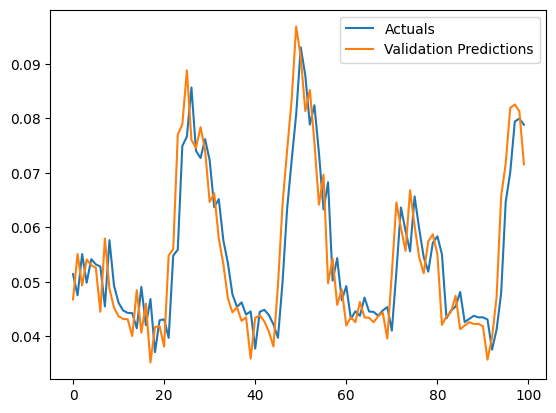

In [11]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.legend(['Actuals','Validation Predictions'])

In [12]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1},index=df['DateTime'][2436:].index)
test_results

,Test Predictions,Actuals
DateTime,,
2020-11-12 14:00:00,0.070095,0.070841
2020-11-12 15:00:00,0.069333,0.068645
2020-11-12 16:00:00,0.067340,0.059088
2020-11-12 17:00:00,0.058676,0.059466
2020-11-12 18:00:00,0.059018,0.051650
...,...,...
2020-11-30 19:00:00,0.048492,0.052057
2020-11-30 20:00:00,0.052313,0.044937
2020-11-30 21:00:00,0.045880,0.048803


In [38]:
# print(target.head())
# plt.plot(test_results['Test Predictions'])#[:100])
# plt.plot(target)#[:100])
# # plt.legend(['Actuals','Test Predictions'])
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error as mse
# from sklearn.metrics import r2_score as r2
# from sklearn.metrics import mean_absolute_percentage_error as mape

# def plot_predictions2(model, X, y, y_all):
#     predictions = model.predict(X).flatten()
#     df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y, 'Target': y_all})
#     plt.plot(df[['Actuals', 'Target']])
#     plt.plot(df['Predictions'])
#     plt.legend(['Actuals', 'Target', 'Test Predictions'])
#     return df, mse(y, predictions), r2(y, predictions), mape(y, predictions)

# final, mse_val, r2_val, mape_value = plot_predictions2(model1, X_test1, y_test1, target)
# print(mse_val, r2_val, mape_value)



ValueError: array length 442 does not match index length 2878

Text(0, 0.5, 'Active Power in MW')

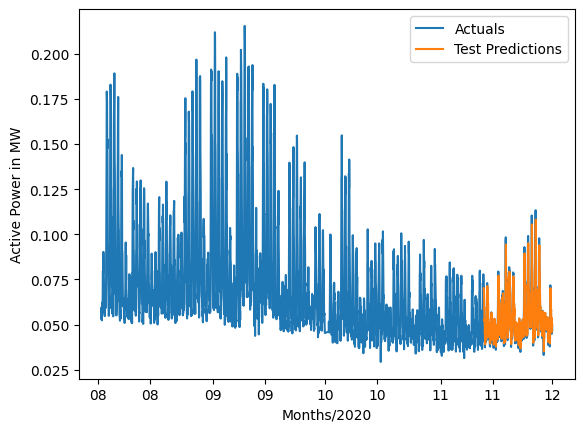

In [46]:
#fig=plt.plot(test_results['Test Predictions'])#[:100])
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
fig=plt.plot(target)#[:100])    
fig=plt.plot(test_results['Test Predictions']) 
plt.legend(['Actuals','Test Predictions'])    
plt.xlabel("Months/2020")
plt.ylabel("Active Power in MW")                           
#fig.autofmt_xdate()

In [14]:
scores = model1.evaluate(X_test1, y_test1)

LSTM_accuracy = scores[1]*10000

print('Test accuracy: ', LSTM_accuracy, '%')

14/14 [==============================] - 1s 923us/step - loss: 4.8694e-05 - root_mean_squared_error: 0.0070
Test accuracy:  69.78118792176247 %


4.869413870970758e-05 0.7332875220003601 0.09347198959797866


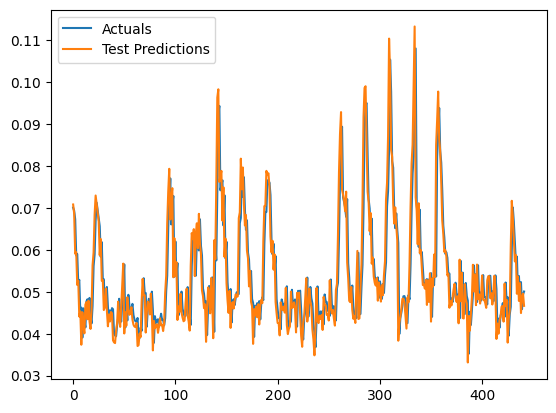

In [32]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_percentage_error as mape

def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  plt.legend(['Actuals','Test Predictions'])
  return df, mse(y, predictions), r2(y,predictions), mape (y,predictions)

final, mse_val, r2_val, mape_value = plot_predictions1(model1, X_test1, y_test1)
print(mse_val, r2_val, mape_value)

In [16]:
target.head()

DateTime
2020-08-02 00:00:00    0.056684
2020-08-02 01:00:00    0.059487
2020-08-02 02:00:00    0.052799
2020-08-02 03:00:00    0.055698
2020-08-02 04:00:00    0.052330
Name: Combined Active Power in MW, dtype: float64

In [17]:
#Weather Data + Time
temp_df = pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"]})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds
DateTime,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09
...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09


In [18]:
#Adding into consideration the time as a periodic function

day = 60*60*24
month= 30*day
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Month sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / month))
temp_df['Month cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / month))
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09,8.660254e-01,0.500000,-0.719340,0.694658
...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09,-9.659258e-01,0.258819,-0.622515,0.782608
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09,-8.660254e-01,0.500000,-0.615661,0.788011
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09,-7.071068e-01,0.707107,-0.608761,0.793353


In [19]:
temp_df.drop("Seconds",axis=1,inplace=True)
temp_df.head()

,Power,Avg Temp,High Temp,Low Temp,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,8.660254e-01,0.500000,-0.719340,0.694658


In [20]:
#Function to create timeseries for multiple parameters
def df_to_X_y2(df, window_size=1):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [21]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((2877, 1, 8), (2877,))

In [22]:
X2_train, y2_train = X2[:2000], y2[:2000]
X2_val, y2_val = X2[2000:2435], y2[2000:2435]
X2_test, y2_test = X2[2435:], y2[2435:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((2000, 1, 8), (2000,), (435, 1, 8), (435,), (442, 1, 8), (442,))

In [23]:
#Standardization for the temperatures. Dividing mean/std 
avg_temp_training_mean = np.mean(X2_train[:, :, 1])
avg_temp_training_std = np.std(X2_train[:, :, 1])
hi_temp_training_mean=np.mean(X2_train[:, :, 2])
hi_temp_training_std=np.std(X2_train[:, :, 2])
low_temp_training_mean = np.mean(X2_train[:, :, 3])
low_temp_training_std=np.std(X2_train[:, :, 3])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  return X

preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 0.07168051, -1.02806753, -1.05114388, ..., -0.96592583,
          0.97629601, -0.21643961]],

       [[ 0.07084134, -0.94875434, -1.03141483, ..., -0.8660254 ,
          0.97437006, -0.22495105]],

       [[ 0.06864545, -0.92892604, -0.99195674, ..., -0.70710678,
          0.97236992, -0.23344536]],

       ...,

       [[ 0.04493744, -2.35656353, -2.35326096, ...,  0.5       ,
         -0.61566148,  0.78801075]],

       [[ 0.04880258, -2.41604843, -2.4519062 , ...,  0.70710678,
         -0.60876143,  0.79335334]],

       [[ 0.04958546, -2.45570503, -2.4519062 , ...,  0.8660254 ,
         -0.60181502,  0.79863551]]])

In [24]:
model4 = Sequential()
model4.add(InputLayer((1, 8)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


In [25]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [26]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp4])

Epoch 1/50
63/63 [==============================] - 3s 11ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588


KeyboardInterrupt: 

In [ ]:
plot_predictions1(model4, X2_test, y2_test)
from keras.models import load_model

model = load_model('model4')
scores = model4.evaluate(X2_test, y2_test)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', LSTM_accuracy, '%')

In [ ]:
plot_predictions1(model4, X2_train, y2_train)
from keras.models import load_model

model = load_model('model4')
scores = model4.evaluate(X2_train, y2_train)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', LSTM_accuracy, '%')

In [ ]:
#Prediction without using time as a parameter (Just Temperature)
new_df= pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"]})
new_df

In [ ]:
X3, y3 = df_to_X_y2(new_df)
X3.shape, y3.shape

In [ ]:
X3_train, y3_train = X3[:2000], y3[:2000]
X3_val, y3_val = X3[2000:2435], y3[2000:2435]
X3_test, y3_test = X3[2435:], y3[2435:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

In [ ]:
avg_temp_training_mean = np.mean(X3_train[:, :, 1])
avg_temp_training_std = np.std(X3_train[:, :, 1])
hi_temp_training_mean=np.mean(X3_train[:, :, 2])
hi_temp_training_std=np.std(X3_train[:, :, 2])
low_temp_training_mean = np.mean(X3_train[:, :, 3])
low_temp_training_std=np.std(X3_train[:, :, 3])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  return X

preprocess(X3_train)
preprocess(X3_val)
preprocess(X3_test)

In [ ]:
model5 = Sequential()
model5.add(InputLayer((1, 4)))
model5.add(LSTM(150))
model5.add(Dense(8, 'relu'))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

In [ ]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=50, callbacks=[cp4])

In [ ]:
final, mse = plot_predictions1(model5, X3_test, y3_test)
final



In [ ]:

final=final.set_index(df['DateTime'][2436:].index)
print(final)